In [2]:
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt
from matplotlib import pyplot
import numpy


# date-time parsing function for loading the dataset

#Converting Strings to datetime

def parser(x):
	return datetime.strptime('19'+x, '%Y-%m')
series = read_csv('Tourists_90-99.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)

# frame a sequence as a supervised learning problem

#The LSTM model in Keras assumes that your data is divided into input (X) and output (y) components.

#For a time series problem, we can achieve this by using the observation from the last time step (t-1) as the input and the observation at the current time step (t) as the output.

def timeseries_to_supervised(data, lag=1):
	df = DataFrame(data)
	columns = [df.shift(i) for i in range(1, lag+1)]
	columns.append(df)
	df = concat(columns, axis=1)
	df.fillna(0, inplace=True)
	return df



<ipython-input-2-a0b8333b9f65>:5: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import datetime


In [3]:
#Calculating Difference between series

# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return Series(diff)


In [4]:
# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]


In [5]:
#Values must be calculated on the training dataset and applied to scale the test dataset and any forecasts.

# scale train and test data to [-1, 1]
def scale(train, test):
	# fit scaler
	scaler = MinMaxScaler(feature_range=(-1, 1))
	scaler = scaler.fit(train)
	# transform train
	train = train.reshape(train.shape[0], train.shape[1])
	train_scaled = scaler.transform(train)
	# transform test
	test = test.reshape(test.shape[0], test.shape[1])
	test_scaled = scaler.transform(test)
	return scaler, train_scaled, test_scaled


In [6]:
# inverse scaling for a forecasted value
def invert_scale(scaler, X, value):
	new_row = [x for x in X] + [value]
	array = numpy.array(new_row)
	array = array.reshape(1, len(array))
	inverted = scaler.inverse_transform(array)
	return inverted[0, -1]


In [7]:
#The line below creates a single LSTM hidden layer that also specifies the expectations of the input layer

# fit an LSTM network to training data
def fit_lstm(train, batch_size, nb_epoch, neurons):
	X, y = train[:, 0:-1], train[:, -1]
	X = X.reshape(X.shape[0], 1, X.shape[1])
	model = Sequential()
	model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
	model.add(Dense(1))
	model.compile(loss='mean_squared_error', optimizer='adam')
	for i in range(nb_epoch):
		model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
		model.reset_states()
	return model


In [8]:
# make a one-step forecast
def forecast_lstm(model, batch_size, X):
	X = X.reshape(1, 1, len(X))
	yhat = model.predict(X, batch_size=batch_size)
	return yhat[0,0]


In [9]:
# load dataset
series = read_csv('Tourists_90-99.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)


In [10]:
# transform data to be stationary
raw_values = series.values
diff_values = difference(raw_values, 1)


In [11]:
# transform data to be supervised learning
supervised = timeseries_to_supervised(diff_values, 1)
supervised_values = supervised.values


In [12]:
# split data into train and test-sets
train, test = supervised_values[0:-12], supervised_values[-12:]


In [13]:
# transform the scale of the data
scaler, train_scaled, test_scaled = scale(train, test)


In [14]:
# fit the model
lstm_model = fit_lstm(train_scaled, 1, 3000, 4)
# forecast the entire training dataset to build up state for forecasting
train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
lstm_model.predict(train_reshaped, batch_size=1)


array([[ 0.20472434],
       [ 0.34944418],
       [ 0.16955832],
       [ 0.25790057],
       [ 0.01171944],
       [ 0.07463744],
       [ 0.23044375],
       [-0.07370728],
       [-0.51815784],
       [-0.6261995 ],
       [-0.04431835],
       [ 0.10624734],
       [ 0.28798327],
       [ 0.39860424],
       [ 0.5853931 ],
       [ 0.57712173],
       [ 0.45014444],
       [ 0.46689084],
       [ 0.5164983 ],
       [ 0.27156016],
       [ 0.31284502],
       [-0.37141135],
       [-0.18550143],
       [ 0.0792354 ],
       [ 0.2735043 ],
       [ 0.52702606],
       [ 0.33706638],
       [ 0.46374103],
       [ 0.4936197 ],
       [ 0.30996683],
       [ 0.45824912],
       [ 0.20999208],
       [-0.24191256],
       [-0.38620922],
       [ 0.21761283],
       [ 0.04324496],
       [ 0.28429475],
       [ 0.5391288 ],
       [ 0.4768745 ],
       [ 0.40323403],
       [ 0.22430214],
       [ 0.20993558],
       [ 0.28907213],
       [ 0.27978012],
       [-0.05234876],
       [ 0

In [15]:
# walk-forward validation on the test data
predictions = list()
for i in range(len(test_scaled)):
	# make one-step forecast
	X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
	yhat = forecast_lstm(lstm_model, 1, X)
	# invert scaling
	yhat = invert_scale(scaler, X, yhat)
	# invert differencing
	yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
	# store forecast
	predictions.append(yhat)
	expected = raw_values[len(train) + i + 1]
	print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


Month=1, Predicted=67012.430199, Expected=359046.000000
Month=2, Predicted=541693.298184, Expected=371727.000000
Month=3, Predicted=576132.496956, Expected=409483.000000
Month=4, Predicted=550936.191297, Expected=426558.000000
Month=5, Predicted=578107.412249, Expected=691313.000000
Month=6, Predicted=770531.453859, Expected=784642.000000
Month=7, Predicted=863803.707358, Expected=931895.000000
Month=8, Predicted=1029722.112896, Expected=1079249.000000
Month=9, Predicted=1077453.436667, Expected=876261.000000
Month=10, Predicted=655566.312007, Expected=800513.000000
Month=11, Predicted=536148.189716, Expected=435790.000000
Month=12, Predicted=443947.756641, Expected=320808.000000


Test RMSE: 148391.709


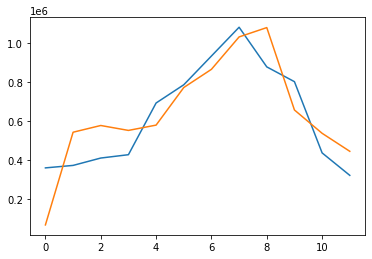

In [16]:
# report performance
rmse = sqrt(mean_squared_error(raw_values[-12:], predictions))
print('Test RMSE: %.3f' % rmse)
# line plot of observed vs predicted
pyplot.plot(raw_values[-12:])
pyplot.plot(predictions)
pyplot.show()

#Orange line is Predicted values

#Blue line is Expected values

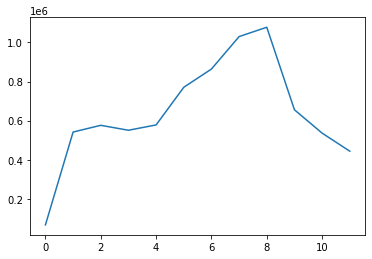

In [17]:
pyplot.plot(predictions)